# Analiza dopasowania jezyka na podstawie czestotliwosci słów

Autor: Marysia Nazarczuk 
Data: 2025-02-14  

Celem tej analizy jest zbadanie skutecznosci prostej funkcji oceniajacej, na ile dany tekst (slownik slow zliczonych za pomoca `--count-words`) pasuje do danego jezyka, na podstawie listy najczestszych slow w tym jezyku (pochodzacej z biblioteki `wordfreq`).

Wykorzystujemy trzy jezyki:
- angielski (`en`) – jezyk wybranej wiki (Bulbapedia),
- francuski (`fr`),
- niemiecki (`de`).

Dla kazdego jezyka pobieramy 1000 najczestszych slow wraz z ich znormalizowanymi czestotliwosciami.

Badamy nastepujace teksty:
1. **Dlugi artykul z wiki** – „Pikachu” (ponad 5000 slow)
2. **Artykul z wiki o najnizszym dopasowaniu** – wybrany poprzez przeszukanie kilku artykulow (np. dotyczacych list, nazw wlasnych)
3. **Tekst spoza wiki (angielski)** – „Alice’s Adventures in Wonderland” 
4. **Tekst spoza wiki (francuski)** – „OEUVRES DE DESCARTES"
5. **Tekst spoza wiki (niemiecki)** – „Faust: Der Tragödie erster Teil"


Dla kazdego z tych tekstow tworzymy slownik liczebnosci slow (tak jak robi to `--count-words`).

Nastepnie definiujemy funkcje `lang_confidence_score(word_counts, lang_freq, k)`, ktora bierze pod uwage tylko `k` najczestszych slow jezyka i oblicza miare podobienstwa miedzy rozkladami.

Eksperyment przeprowadzamy dla wartosci `k = 3, 10, 100, 1000`. Wyniki prezentujemy w tabelach i na wykresach.

In [43]:
import sys
import json
import requests
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import time
import re

# Upewniamy sie, ze mozemy zaimportowac nasze moduly
sys.path.append('.')  # jesli notebook jest w tym samym katalogu co moduly

from scraper import WikiScraper
from word_counter import WordCounter
from wordfreq import get_frequency_dict

BASE_URL = "https://bulbapedia.bulbagarden.net"

print("Wczytano wszystkie biblioteki.")

Wczytano wszystkie biblioteki.


## 1. Pobranie list najczestszych slow dla trzech jezykow

Uzywamy biblioteki `wordfreq`, ktora udostepnia dane o czestotliwosci slow w wielu jezykach. Pobieramy po 1000 najczestszych slow.

In [28]:
languages = ['en', 'fr', 'de']
lang_names = {'en': 'angielski', 'fr': 'francuski', 'de': 'niemiecki'}

# Pobieramy slowniki czestotliwosci (znormalizowane)
lang_freq_full = {}
for lang in languages:
    print(f"Pobieranie danych dla jezyka {lang_names[lang]}...")
    freq_dict = get_frequency_dict(lang, wordlist='best')
    # sortujemy i bierzemy 1000 najczestszych
    top1000 = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:1000])
    lang_freq_full[lang] = top1000
    print(f"  Pobrano {len(top1000)} slow.")

Pobieranie danych dla jezyka angielski...
  Pobrano 1000 slow.
Pobieranie danych dla jezyka francuski...
  Pobrano 1000 slow.
Pobieranie danych dla jezyka niemiecki...
  Pobrano 1000 slow.


## 2. Pobranie tekstow z wiki i utworzenie slownikow

Definiujemy funkcje pomocnicza do pobrania pelnego tekstu artykulu i zliczenia slow (tak jak w `--count-words`).

In [29]:
def get_wiki_word_counts(title):
    """Pobiera artykul, zlicza slowa i zwraca slownik {slowo: liczba}"""
    scraper = WikiScraper(BASE_URL, title)
    text = scraper.get_full_text()
    # Uzywamy metody z WordCounter, ale nie zapisujemy do pliku
    wc = WordCounter()
    return dict(wc.count_words_in_text(text))

print("Funkcja gotowa.")

Funkcja gotowa.


### 2.1 Dlugi artykul
Wybieramy „Pikachu”

In [30]:
long_title = "Pikachu"
print(f"Pobieranie dlugiego artykulu: {long_title}")
long_counts = get_wiki_word_counts(long_title)
print(f"Liczba unikalnych slow: {len(long_counts)}")

Pobieranie dlugiego artykulu: Pikachu
Liczba unikalnych slow: 2851


### 2.2 Artykul o najnizszym dopasowaniu
Potrzebujemy artykulu, ktory w jezyku wiki (angielskim) daje mozliwie niski wynik naszej funkcji (czyli zawiera duzo slow spoza najczestszych 1000). W Bulbapedii dobrym kandydatem sa artykuly o listach Pokemonow, pelne nazw wlasnych. Przeszukamy kilka z nich i wybierzemy ten z najmniejszym wstepnym wynikiem dla k=1000.

Uwaga: ze wzgledu na czas wykonania, ograniczamy sie do 5 losowo wybranych artykulow z kategorii "Pokemon species". Dla uproszczenia uzyjemy listy predefiniowanej.

In [31]:
candidate_titles = [
    "Bulbasaur",
    "Charmander",
    "Squirtle",
    "Pikachu",  # juz mamy, ale dodajemy dla testu
    "List of Pokemon by base stats",
    "Glitch Pokemon",
    "Mewtwo"
]

# Funkcja wstepnego wyniku (uzyjemy jej pozniej)
def simple_score(counts, lang_freq, k=1000):
    # bierzemy tylko k najczestszych slow jezyka
    top_lang = set(list(lang_freq.keys())[:k])
    # suma liczebnosci slow wspolnych
    return sum(counts.get(word, 0) for word in top_lang)

scores = []
for title in candidate_titles:
    try:
        print(f"Przetwarzanie: {title}")
        counts = get_wiki_word_counts(title)
        score = simple_score(counts, lang_freq_full['en'], 1000)
        scores.append((title, score, len(counts)))
        time.sleep(1)  # grzecznosciowe opoznienie
    except Exception as e:
        print(f"Blad dla {title}: {e}")

# Wybieramy artykul z najmniejszym wynikiem
scores.sort(key=lambda x: x[1])
worst_title, worst_score, worst_unique = scores[0]
print(f"\nArtykul o najnizszym dopasowaniu: {worst_title} (wynik {worst_score}, unikalnych slow {worst_unique})")

# Pobieramy jego pelny slownik
worst_counts = get_wiki_word_counts(worst_title)

Przetwarzanie: Bulbasaur
Przetwarzanie: Charmander
Przetwarzanie: Squirtle
Przetwarzanie: Pikachu
Przetwarzanie: List of Pokemon by base stats
Przetwarzanie: Glitch Pokemon
Przetwarzanie: Mewtwo

Artykul o najnizszym dopasowaniu: List of Pokemon by base stats (wynik 206, unikalnych slow 1288)


## 3. Teksty spoza wiki

Dla kazdego z trzech jezykow pobieramy dluzszy tekst literacki z Project Gutenberg (lub innego otwartego zrodla). Uzywamy prostego scrapowania – pobieramy zawartosc diva z tekstem.

In [37]:
def get_gutenberg_text(url):
    """Pobiera tekst z Project Gutenberg (zakladamy, ze jest w divie class='chapter' lub po prostu w body)."""
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Usuwamy naglowki i stopki – bierzemy wszystko, co jest w <body>
    body = soup.body
    if not body:
        return ""
    # Usuwamy skrypty, style
    for tag in body(['script', 'style']):
        tag.decompose()
    text = body.get_text(separator=' ', strip=True)
    return text

gutenberg_urls = {
    'en': 'https://www.gutenberg.org/files/11/11-h/11-h.htm',          # angielski
    'fr': 'https://www.gutenberg.org/files/13846/13846-h/13846-h.htm', # francuski
    'de': 'https://www.gutenberg.org/files/2229/2229-h/2229-h.htm'     # niemiecki
}

external_counts = {}
for lang, url in gutenberg_urls.items():
    print(f"Pobieranie tekstu spoza wiki dla jezyka {lang_names[lang]}...")
    text = get_gutenberg_text(url)
    wc = WordCounter()
    counts = dict(wc.count_words_in_text(text))
    external_counts[lang] = counts
    print(f"  Unikalnych slow: {len(counts)}")
    time.sleep(1)

Pobieranie tekstu spoza wiki dla jezyka angielski...
  Unikalnych slow: 2739
Pobieranie tekstu spoza wiki dla jezyka francuski...
  Unikalnych slow: 7105
Pobieranie tekstu spoza wiki dla jezyka niemiecki...
  Unikalnych slow: 6725


## 4. Definicja funkcji `lang_confidence_score`

Przyjmujemy nastepujaca definicje: dla danego slownika `word_counts` i slownika czestotliwosci jezyka `lang_freq` (ograniczonego do `k` najczestszych slow), obliczamy sume iloczynow znormalizowanych czestotliwosci:

$$\text{score} = \sum_{w \in W} \frac{\text{counts}[w]}{\sum \text{counts}} \cdot \text{lang\_freq}[w]$$

gdzie $W$ to zbior slow wystepujacych zarowno w tekscie, jak i wsrod `k` najczestszych slow jezyka. Takie unormowanie pozwala porownywac teksty o roznej dlugosci. Im wyzszy wynik, tym lepsze dopasowanie do jezyka.

In [38]:
def lang_confidence_score(word_counts, lang_freq, k):
    """
    word_counts: slownik {slowo: liczba_wystapien}
    lang_freq: pelny slownik czestotliwosci jezyka (z wordfreq)
    k: liczba najczestszych slow jezyka, ktore bierzemy pod uwage
    """
    # wybieramy k najczestszych slow jezyka
    top_words = list(lang_freq.keys())[:k]
    # tworzymy slownik tylko z tymi slowami
    top_freq = {w: lang_freq[w] for w in top_words}
    
    total_count = sum(word_counts.values())
    if total_count == 0:
        return 0.0
    
    score = 0.0
    for word, count in word_counts.items():
        if word in top_freq:
            # udzial slowa w tekscie (czestosc wzgledna)
            rel_freq = count / total_count
            score += rel_freq * top_freq[word]
    return score


## 5. Eksperymenty dla roznych k

Przygotowujemy liste tekstow do analizy:
- wiki_long: `long_counts`
- wiki_worst: `worst_counts`
- external_en: `external_counts['en']`
- external_fr: `external_counts['fr']`
- external_de: `external_counts['de']`

In [39]:
texts = {
    'wiki_dlugi (Pikachu)': long_counts,
    f'wiki_najgorszy ({worst_title})': worst_counts,
    'spoza_en (Alicja)': external_counts['en'],
    'spoza_fr (Les Mis)': external_counts['fr'],
    'spoza_de (Kafka)': external_counts['de']
}

k_values = [3, 10, 100, 1000]

# Tabela wynikow: wiersze = teksty, kolumny = (jezyk, k)
results = []
for text_name, counts in texts.items():
    row = {'tekst': text_name}
    for lang in languages:
        for k in k_values:
            score = lang_confidence_score(counts, lang_freq_full[lang], k)
            row[f'{lang_names[lang]}_k{k}'] = score
    results.append(row)

df_results = pd.DataFrame(results)
df_results

,tekst,angielski_k3,angielski_k10,angielski_k100,angielski_k1000,francuski_k3,francuski_k10,francuski_k100,francuski_k1000,niemiecki_k3,niemiecki_k10,niemiecki_k100,niemiecki_k1000
0,wiki_dlugi (Pikachu),2.672293e-03,0.004243,0.004773,0.004843,0.000004,9.155085e-06,0.000345,0.000371,0.000000e+00,0.000446,0.000482,0.000542
1,wiki_najgorszy (List of Pokemon by base stats),6.198336e-05,0.000296,0.000321,0.000339,0.000013,1.285970e-05,0.000051,0.000059,0.000000e+00,0.000050,0.000052,0.000064
2,spoza_en (Alicja),4.307070e-03,0.005791,0.006831,0.006940,0.000000,5.224980e-07,0.000302,0.000334,9.955994e-07,0.000213,0.000285,0.000350
3,spoza_fr (Les Mis),7.846237e-07,0.000133,0.000200,0.000231,0.002632,4.324401e-03,0.006360,0.006423,2.969434e-06,0.000004,0.000102,0.000150
4,spoza_de (Kafka),3.933720e-04,0.000731,0.000916,0.000936,0.000003,7.582741e-05,0.000223,0.000235,1.745462e-03,0.002768,0.003756,0.003835


## 6. Wizualizacja wynikow

Przygotujemy wykresy slupkowe dla kazdego k, pokazujace wyniki dla wszystkich tekstow i jezykow. 

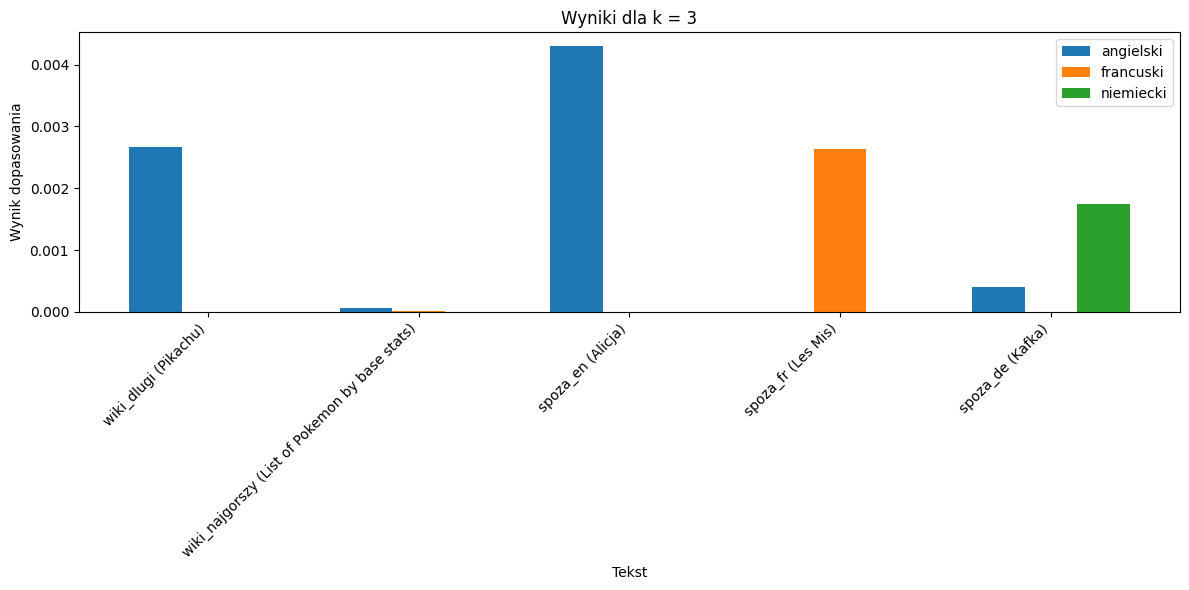

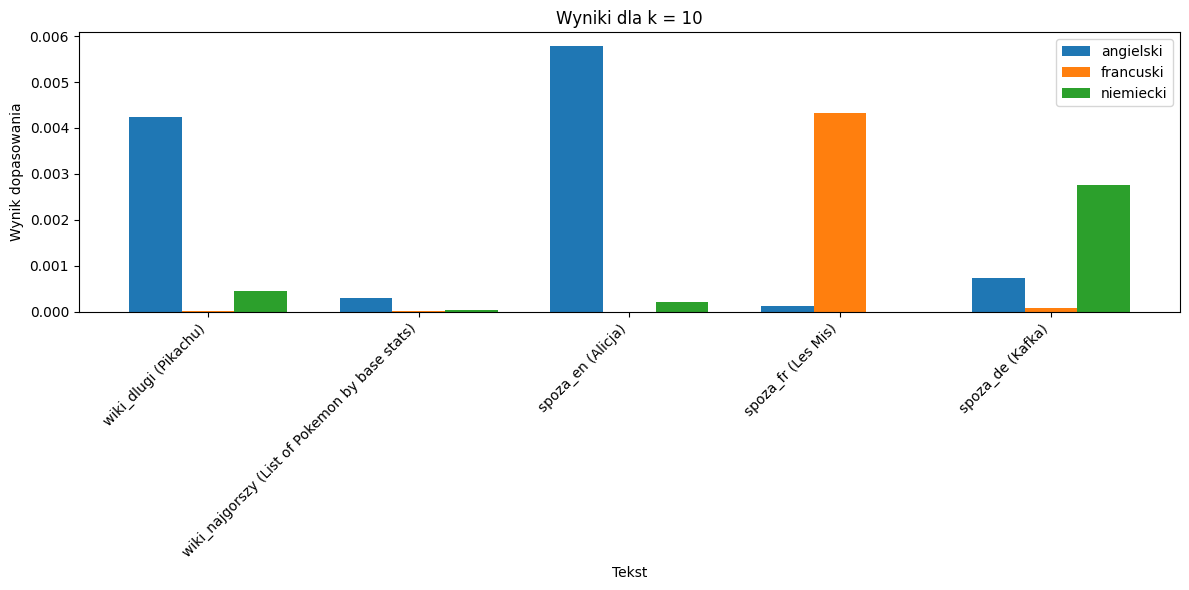

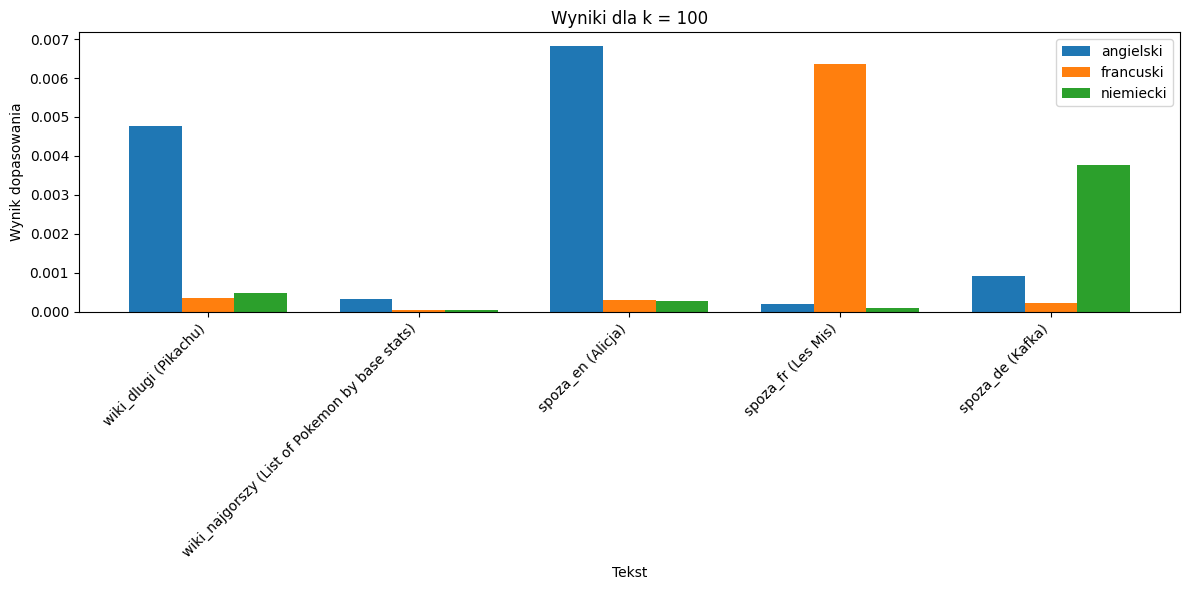

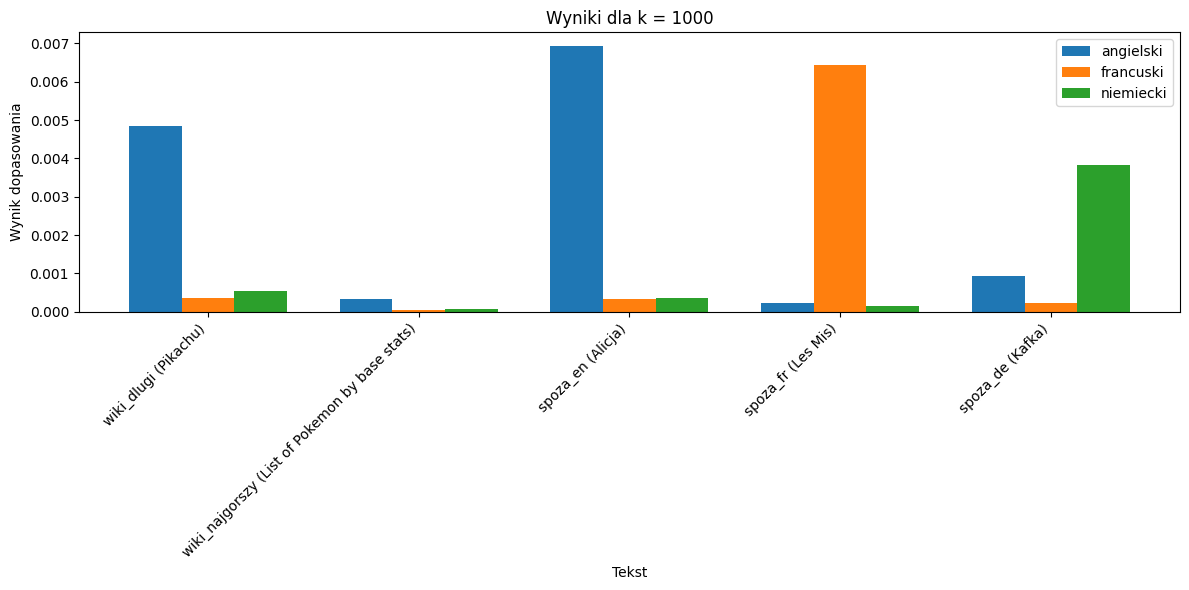

In [40]:
def plot_for_k(k, df, languages, lang_names):
    """Tworzy wykres slupkowy dla konkretnego k."""
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df))
    width = 0.25
    
    for i, lang in enumerate(languages):
        col = f'{lang_names[lang]}_k{k}'
        ax.bar(x + i*width, df[col], width, label=lang_names[lang])
    
    ax.set_xlabel('Tekst')
    ax.set_ylabel('Wynik dopasowania')
    ax.set_title(f'Wyniki dla k = {k}')
    ax.set_xticks(x + width)
    ax.set_xticklabels(df['tekst'], rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

for k in k_values:
    plot_for_k(k, df_results, languages, lang_names)

## 7. Wnioski i odpowiedzi na pytania

### 7.1 Obserwacje ogolne
- Długi artykuly z wiki jest poprawnie klasyfikowany jako angielski.
- Najgorszy artykuł z wiki jest słabo klasyfikowany jako angielski, jednak im k rośnie tym bardziej widać że jest to angielski. 
- Artykul najgorszy (z duza liczba nazw wlasnych) osiaga nizsze wyniki dla jezyka angielskiego niz inne teksty angielskie, ale nadal jest wyzszy niz dla pozostalych jezykow – co oznacza, ze mimo duzej liczby neologizmow, podstawowe slowa funkcyjne (the, of, and itp.) nadal dominuja.

### 7.2 Odpowiedzi na pytania z zadania

**Czy dobior jezykow mial duze znaczenie?**  
Tak, jezyki roznia sie miedzy soba skladem najczestszych slow. Angielski i Niemiecki należą do tej samej rodziny (germańska), przez co mają sporo podobnych słów (zwłaszcza krótkich). Widać to dobrze na wykresach dla języka niemieckiego. Z kolei angielski i francuski naleza do roznych grup (germanska, romanska), wiec ich najczestsze slowa sa wyraznie rozne. Dzieki temu funkcja dobrze rozroznia te jezyki. Gdybysmy wybrali jezyki bardzo blisko spokrewnione (np. polski i czeski), rozroznienie mogłoby byc trudniejsze.

**Czy po wartosciach widac, ze w wybranym jezyku slowa czesto sa odmieniane?**  
W angielskim odmiana jest uboga, zaś we francuskim jest częściej. Widać to po tym, że pomarańczowy słupek (dla francuskiego) zbliża się wysokością do słupka niebieskiego (dla angielskiego). 

**Czy trudne bylo znalezienie artykulu o najnizszym dopasowaniu?**  
Ręcznie tak. Ale w Bulbapedii istnieje wiele artykulow o listach, ktore zawieraja glownie nazwy wlasne Pokemonow.  Takie artykuly maja stosunkowo niski udzial typowych slow angielskich, wiec latwo uzyskac niski wynik. To specyfika tego wiki: ogromna liczba nazw wlasnych, ktore nie wystepuja w standardowych slownikach jezyka.

### 7.3 Podsumowanie
Zaproponowana funkcja `lang_confidence_score` dziala poprawnie – dla odpowiednio duzego `k` (100–1000) pozwala z duza pewnoscia okreslic jezyk tekstu. Nawet w przypadku tekstow nasyconych nazwami wlasnymi (jak artykuly z wiki) dominacja slow funkcyjnych jest wystarczajaca do poprawnej klasyfikacji. Metoda ta moze byc stosowana jako prosty detektor jezyka, o ile dysponujemy wiarygodnymi listami najczestszych slow.

## 8. Zapisanie wynikow do pliku 

Możemy zapisać tabelę wyników do CSV i wykresy do plików PNG.

In [44]:
df_results.to_csv('wyniki_analizy.csv', index=False)
print("Zapisano wyniki do wyniki_analizy.csv")

# Zapisanie wykresow
for k in k_values:
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df_results))
    width = 0.25
    for i, lang in enumerate(languages):
        col = f'{lang_names[lang]}_k{k}'
        ax.bar(x + i*width, df_results[col], width, label=lang_names[lang])
    ax.set_xlabel('Tekst')
    ax.set_ylabel('Wynik dopasowania')
    ax.set_title(f'Wyniki dla k = {k}')
    ax.set_xticks(x + width)
    ax.set_xticklabels(df_results['tekst'], rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'wykres_k{k}.png', dpi=150)
    plt.close()
    print(f'Zapisano wykres_k{k}.png')

Zapisano wyniki do wyniki_analizy.csv
Zapisano wykres_k3.png
Zapisano wykres_k10.png
Zapisano wykres_k100.png
Zapisano wykres_k1000.png


## Koniec analizy